# Eigen Portfolio Construction

## Importing libraries and downloading historical data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt


import scipy 
from scipy.stats import norm
from scipy.stats import skew 
from scipy.stats import kurtosis

import bs4 as bs
import requests

from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
import yfinance as yf

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
req = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
soup = bs.BeautifulSoup(req.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [5]:
stocks = []

for i in table.findAll('tr')[1:]:
    ticker = i.findAll('td')[1].text
    stocks.append(ticker)

In [6]:
stocks = [s.replace('\n', '') for s in stocks]

In [7]:
end = dt.datetime.today()
start = end - relativedelta(years = 15)

In [8]:
df = yf.download(stocks, start = start, end = end)['Adj Close']

[*********************100%***********************]  30 of 30 completed


In [9]:
df.head(5)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-08,2.806425,42.933514,15.836487,33.596062,29.177813,8.2275,11.991920,41.134186,19.655119,NaN,...,16.534935,14.910910,10.655811,38.719112,29.255123,21.652983,12.528875,14.578881,17.393810,36.835480
2009-01-09,2.742244,41.861263,15.196396,33.341042,28.634295,7.8825,11.417622,40.347408,19.148716,NaN,...,16.180136,14.466243,10.286728,38.366615,29.081932,21.442211,12.497420,14.475358,16.946655,36.978859
2009-01-12,2.684117,41.339630,14.880285,32.808475,27.301998,7.7125,11.212513,39.239269,18.762484,NaN,...,16.050604,14.429186,10.392475,38.417873,28.423815,20.769361,11.899740,14.308821,16.784641,36.842640
2009-01-13,2.655357,41.810532,15.006737,31.848373,27.441202,7.4075,11.246696,39.793343,18.196005,NaN,...,16.016811,14.688571,10.263916,38.116631,28.950308,20.558584,11.940180,14.178291,16.894804,37.365986
2009-01-14,2.583304,40.629623,14.090053,30.903276,26.082392,6.9650,10.761277,38.613163,17.852682,NaN,...,15.667638,14.147573,9.672963,37.084721,27.710266,19.520922,11.452599,13.755193,16.940174,36.964520


In [10]:
df.describe()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
count,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,1210.000000,...,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000,3775.000000
mean,54.575147,132.100902,84.019161,156.517800,107.214504,104.226381,28.349748,84.528714,86.538341,47.150869,...,49.790897,104.238028,61.072761,80.418084,94.921756,186.217678,103.201622,33.105305,40.697877,81.109123
std,55.749049,70.939765,44.225975,98.471147,63.053545,75.486612,14.046135,32.328424,42.819539,8.535988,...,25.300782,102.241189,41.491594,36.808959,44.434583,161.498783,77.354376,10.858164,14.992549,38.011357
min,2.367448,32.681908,8.107903,22.244299,14.853500,6.442500,9.311854,31.570793,13.380930,18.160524,...,12.019275,11.304625,8.044827,28.515284,23.428291,13.254446,9.531476,11.783733,13.991773,33.279533
25%,15.212508,62.671457,48.804323,62.034142,63.384554,38.382500,15.851344,64.543591,44.656006,41.103422,...,29.013585,24.067248,23.408482,49.485039,52.884521,46.614428,31.555336,25.990870,26.297559,53.666183
50%,27.366131,128.000916,74.702621,129.210678,79.530220,76.320000,23.185398,78.522720,93.053856,48.703558,...,43.703869,49.755623,51.246372,67.555618,94.671570,122.762199,74.967514,33.316914,40.837059,63.682728
75%,75.874119,198.127991,111.189358,214.665001,133.945045,159.955002,41.266008,95.755066,108.865395,53.590699,...,68.454449,170.111832,90.833366,111.828327,124.460747,275.510666,182.731438,42.187094,53.666752,112.925755
max,198.110001,304.049988,192.847046,430.299957,298.119995,309.959991,59.704548,180.690506,201.254089,64.523323,...,117.220001,382.700012,173.070908,157.220612,193.070007,551.089966,262.380005,52.166176,71.871780,169.151764


## Data cleaning and visualization

Since some stocks have missing values, we will drop those with missing values exceeding 20%. One stocks fit this criteria; Dow which operates in the chemical industry

In [11]:
lim = df.isnull().mean().sort_values(ascending = False)
lim.head(10)
drop_lim = sorted(list(lim[lim > 0.2].index))
df.drop(labels = drop_lim, axis = 1, inplace = True)

In [35]:
drop_lim

['DOW']

The dataframe comprises 29 stocks

In [38]:
df.shape

(3775, 29)

In [12]:
df.isnull().values.any()

False

Computing returns and removing values that lie beyond 3 stadard deviations from the mean

In [25]:
df_ret = df.pct_change()
df_ret = df_ret[df_ret.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

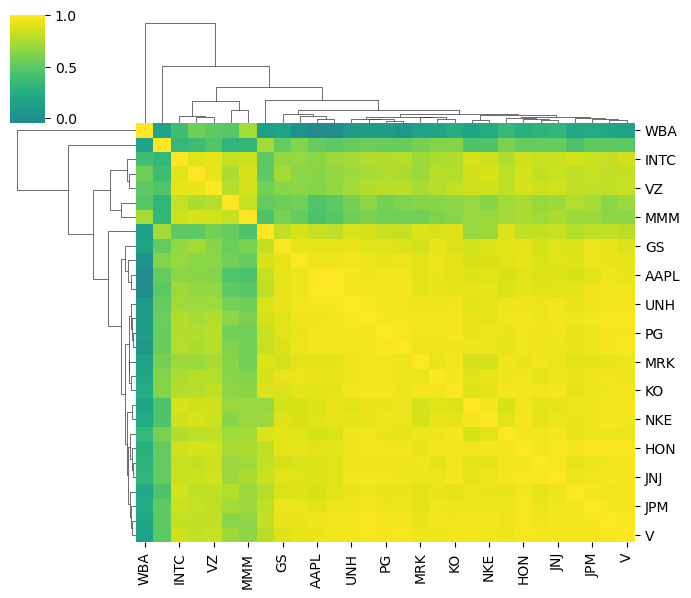

In [26]:
sns.clustermap(df.corr(), annot = False, figsize = (7, 6), cmap = 'viridis', center=0)

## Scaling the data and applying pricinpal component analysis

In [27]:
sc = StandardScaler()

In [28]:
sc_ret = pd.DataFrame(sc.fit_transform(df_ret),columns = df_ret.columns, index = df_ret.index)

In [29]:
split = int(len(df_ret) * .8)

X_train = df_ret[:split]
X_test = df_ret[split:]

sc_train = sc_ret[:split]
sc_test = sc_ret[split:]

In [30]:
pca = PCA()

In [31]:
pca_train = pca.fit(sc_train)

Using PCA, we inspect the explained variance. It can be seen from the figures below that the first factor accounts for almost 40% of variance in daily returns. The cumulative explained variance plot indicates that 9 factors explain around 70% of the variance in the returns. 

In [39]:
components = np.arange(0, 9 + 1)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_[:10]) * 100
exp_var_contrib = np.sort(pca.explained_variance_ratio_[:10]) * 100

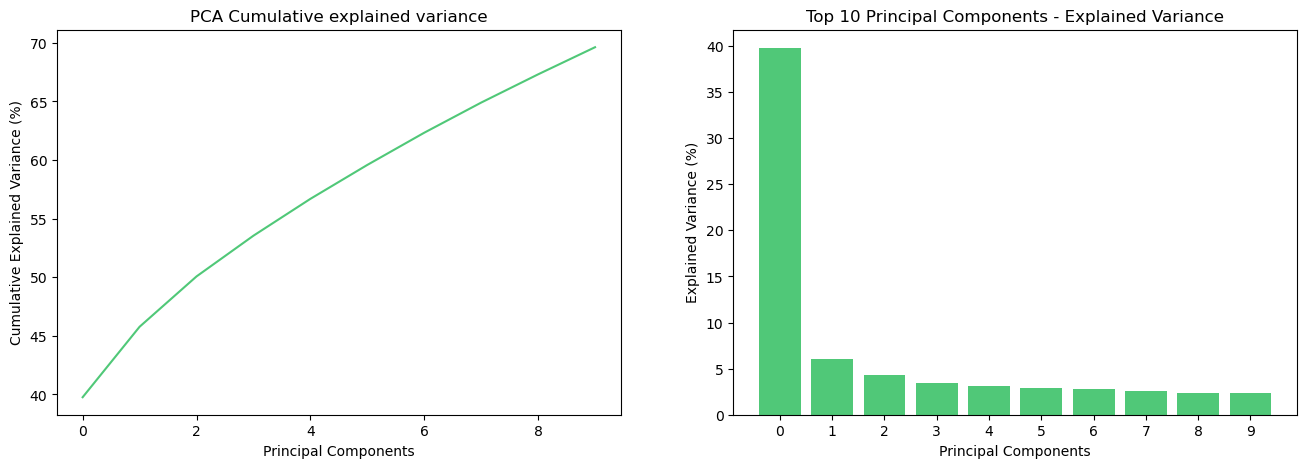

In [40]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 5))
axes[0].plot(exp_var_cumul, color = '#50C878')
axes[1].bar(components, exp_var_contrib[::-1], color = '#50C878')
axes[0].set_title('PCA Cumulative explained variance')
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Cumulative Explained Variance (%)')
axes[1].set_title('Top 10 Principal Components - Explained Variance')
axes[1].set_xlabel('Principal Components')
axes[1].set_ylabel('Explained Variance (%)')
axes[1].set_xticks(components)
plt.show()

##  Portfolio inspection

We can inspect the composition of each portfolio using the code below. We construct 6 portfolios with different weight allowcations for the stocks and plot the respective weight for each of those portfolios.
We notice that thre is not a lot of variation in weight allocation for Portfolio 0, which is nearly the same as the equally weighted portfolio. We will see this again when backtesting the portfolios. Each portfolio has a unique allocation startegy. Portfolio 2, for instance, allocates more weight to AAPL, CRM, MSFT which operates in the IT sector.

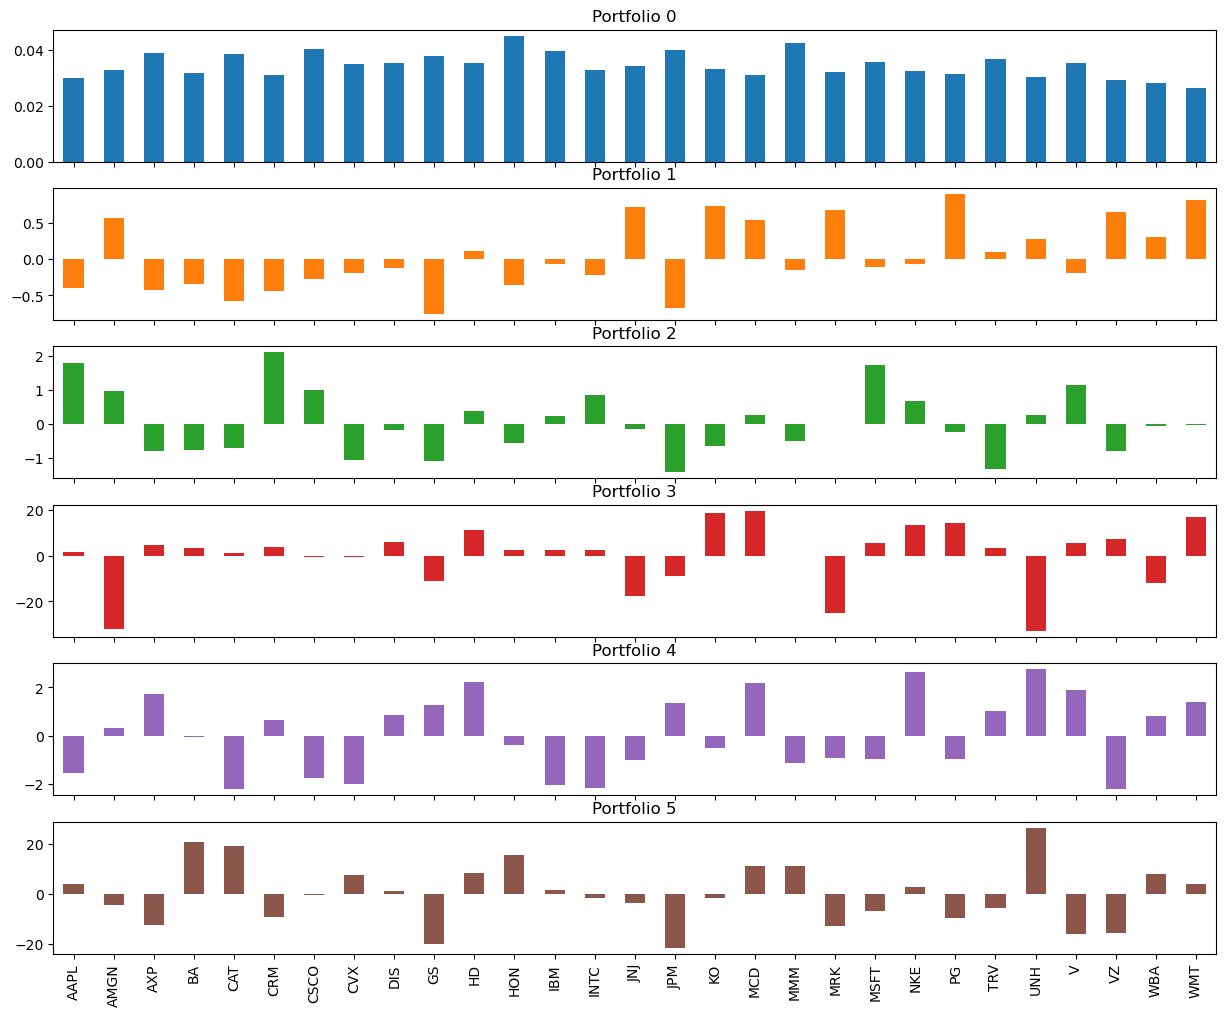

In [41]:
ptfs = pd.DataFrame(pca.components_[: 6], columns = df.columns)
eigen_ptfs = ptfs.div(ptfs.sum(1), axis = 0)
eigen_ptfs.index = [f'Portfolio {i}' for i in range(6)]
eigen_ptfs.T.plot.bar(subplots = True, figsize = (15, 12), legend = False)
plt.show()

Each eigenportfolio accounts for a unique and independent risk factor. We saw before that the first factor explains around 40% of variance in returns, this factor is commonly refered to as the market factor, and since the respective portfolio accounts for most of the variance it represents a systematic risk factor

## Finding the optimal eigenportfolio

In order to select the best eigen portfolio, we define two metrics; Sharpe ratio and Probabilistic Sharpe
ratio(for more explanation on the latter metric please refer to the paper in the references). Hence, portfolio ranking is based on thr risk-adjusted performance which accounts for annual returns and volatility.

In [42]:
class PortfolioMetrics:
    def __init__(self, returns, trading_days):
        self.returns = returns
        self.trading_days = trading_days
        self.obs = self.returns.shape[0] / self.trading_days

    def annualized_sharpe(self):
        ann_ret = np.power(np.prod(1 + self.returns), (1 / self.obs)) - 1
        ann_vol = self.returns.std() * np.sqrt(self.trading_days)
        ann_sharpe = ann_ret / ann_vol

        return ann_ret, ann_vol, ann_sharpe

    
    def std_sharpe_ratio(self, annualized_sharpe, skewness, kurtosis):
        return np.sqrt((
            1 - skewness * annualized_sharpe + (kurtosis - 1) / 4 * annualized_sharpe ** 2) / (self.obs - 1))
    

    def probabilistic_sharpe(self, annualized_sharpe, bench_sharpe, skewness, kurtosis):
        sr_diff = annualized_sharpe - bench_sharpe
        sr_vol = self.std_sharpe_ratio(annualized_sharpe, skewness, kurtosis)
        psr = norm.cdf(sr_diff / sr_vol)

        return psr

In [43]:
benchmark_return = (X_test * (1 / len(pca.components_))).sum(axis=1)

In [44]:
benchmark_metrics = PortfolioMetrics(benchmark_return, 252)
benchmark_sharpe = benchmark_metrics.annualized_sharpe()[2]

The next function loops over pca components and computes weights for each eigenportfolio. We use the PortfolioMetrics class to identify the portfolio with the highest Sharpe and probabilistic Sharpe ratios.

In [45]:
def portfolio_select():
    portfolios = len(pca.components_)
    ann_ret = np.zeros(portfolios)
    ann_sharpe = np.zeros(portfolios)
    prob_sharpe = np.zeros(portfolios)
    ann_vol = np.zeros(portfolios)
    components = pca.components_
    
    for i in range(portfolios):
        
        weight = components[i] / sum(components[i])
        eigen_ptf = pd.DataFrame(data = {'weights': weight.squeeze() * 100}, index = df.columns.values)
        eigen_ptf.sort_values(by = 'weights', ascending = False, inplace = True)
        eigen_ptf_returns = np.dot(X_train.loc[:, eigen_ptf.index], weight)
        eigen_ptf_returns = pd.Series(eigen_ptf_returns.squeeze(), index = X_train.index)
        eigen_metrics = PortfolioMetrics(eigen_ptf_returns, 252)
        y_ret, y_vol, y_sharpe = eigen_metrics.annualized_sharpe()
        probabilistic_sharpe = eigen_metrics.probabilistic_sharpe(y_sharpe, benchmark_sharpe,
                                                                 eigen_ptf_returns.skew(),
                                                                 eigen_ptf_returns.kurtosis())
        ann_ret[i] = y_ret
        ann_vol[i] = y_vol
        ann_sharpe[i] = y_sharpe
        prob_sharpe[i] = probabilistic_sharpe
        
        
        ann_sharpe = np.nan_to_num(ann_sharpe)
        prob_sharpe = np.nan_to_num(prob_sharpe)

    best_prob_sharpe = np.argmax(prob_sharpe)


    print('Eigen portfolio number %d has the highest Sharpe and Probabilistic Sharpe.Return %.2f%%, vol = %.2f%%, Sharpe = %.2f Probabilistic Sharpe = %.2f' % 
          (best_prob_sharpe, ann_ret[best_prob_sharpe]*100,  ann_vol[best_prob_sharpe]*100, 
           ann_sharpe[best_prob_sharpe], prob_sharpe[best_prob_sharpe]))
    res = pd.DataFrame(data = {'Return': ann_ret, 'Volatility': ann_vol, 'Sharpe': ann_sharpe,
                                 'Probabilistic Sharpe': prob_sharpe})
    res.dropna(inplace=True)
    res.sort_values(by = 'Probabilistic Sharpe', ascending = False, inplace = True)
    print(res.head(30))

portfolio_select()

Eigen portfolio number 0 has the highest Sharpe and Probabilistic Sharpe.Return 20.82%, vol = 12.14%, Sharpe = 1.71 Probabilistic Sharpe = 0.83
          Return  Volatility         Sharpe  Probabilistic Sharpe
0   2.082082e-01    0.121450   1.714360e+00          8.250315e-01
1   1.798134e-01    0.561408   3.202899e-01          1.426450e-03
16  2.105522e-01    0.865925   2.431529e-01          1.022396e-03
8   1.949026e-01    0.832644   2.340767e-01          6.672225e-04
23  1.554800e-01    0.769966   2.019311e-01          5.412260e-04
21 -1.108255e-01    1.681424  -6.591173e-02          2.725293e-05
2  -6.240651e-02    0.795449  -7.845446e-02          2.257568e-05
9  -1.000000e+00    9.472985  -1.055634e-01          1.687152e-05
11 -5.026620e-01    1.883165  -2.669241e-01          3.056071e-06
27 -3.617085e-01    1.316120  -2.748294e-01          1.600793e-06
18 -8.721174e-01    2.704652  -3.224508e-01          1.055808e-06
13 -9.998458e-01    3.540803  -2.823782e-01          9.342286e-0

## Backtesting

We backtest the eigenportfolio construction by computing the returns of all eigenportfolios and comparing them to the returns of the benchmark index portfolio, which assigns equal weights to the stocks. We also plot the eigenperfolios that performed best and one underperformer.

In [46]:
weights = pd.DataFrame()
for i in range(len(pca.components_)):
    weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])
weights = weights.values.T

In [47]:
def test(weight):
    
    eigen_ptf = pd.DataFrame(data = {'weights': weight.squeeze()}, index = sc_ret.columns)
    eigen_ptf.sort_values(by = 'weights', ascending = False, inplace = True)
    eigen_ptf_ret = np.dot(X_test.loc[:, eigen_ptf.index], weight)
    eigen_ret = pd.Series(eigen_ptf_ret.squeeze(), index = X_test.index)
    eigen_metrics = PortfolioMetrics(eigen_ret, 252)
    returns, vol, sharpe = eigen_metrics.annualized_sharpe()
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    equ_ret = benchmark_return
    df = pd.DataFrame({'Eigen porfolio return': eigen_ret, 'Benchmark index return': equ_ret}, index=sc_test.index)
    np.cumprod(df + 1).plot(title = 'Benchmark index returns vs eigen portfolio returns', figsize = (16, 5), 
                           color = ['#50C878', 'black'], linewidth = 2)
    plt.show()

## Results

The eigenportfolio comprised of the sigular vector is nothing more than the equally weighted portfolio

Current Eigen-Portfolio:
Return = 15.91%
Volatility = 12.20%
Sharpe = 1.30


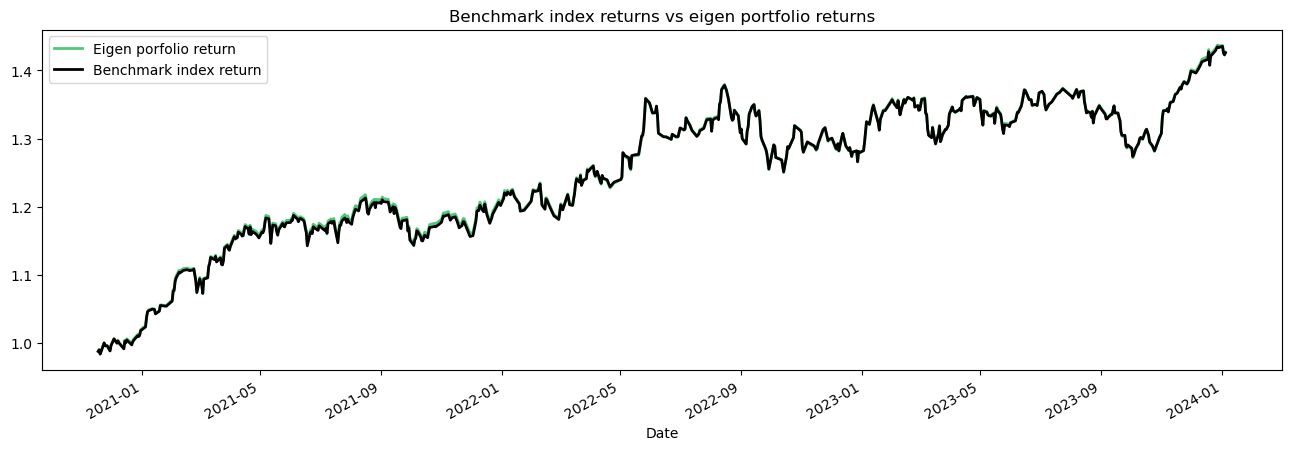

In [48]:
test(weight = weights[0])

The results produce eigenportfolios that outperform and underperform the equally weighted portfolio

Current Eigen-Portfolio:
Return = 50.12%
Volatility = 85.38%
Sharpe = 0.59


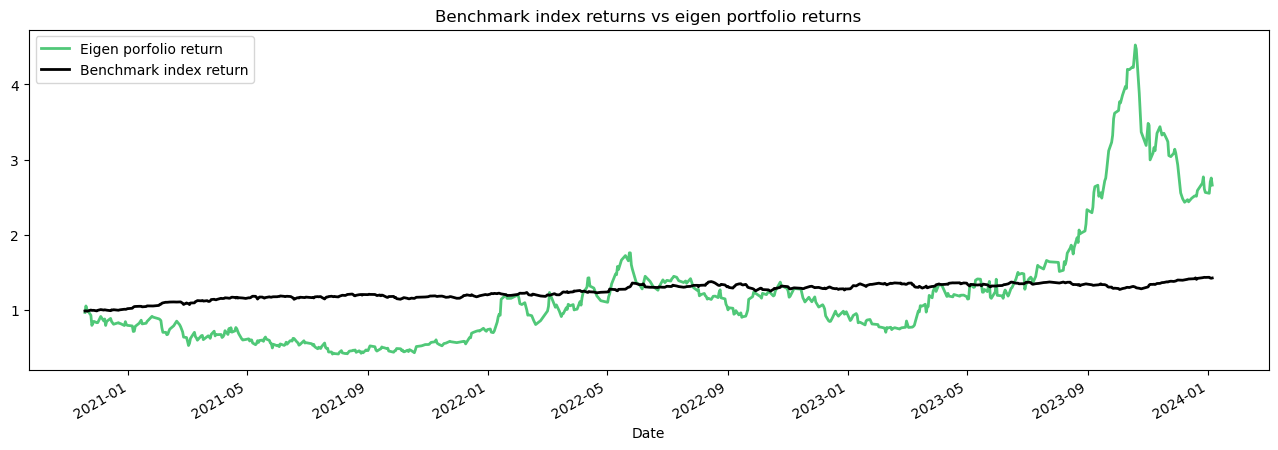

Current Eigen-Portfolio:
Return = 34.59%
Volatility = 84.10%
Sharpe = 0.41


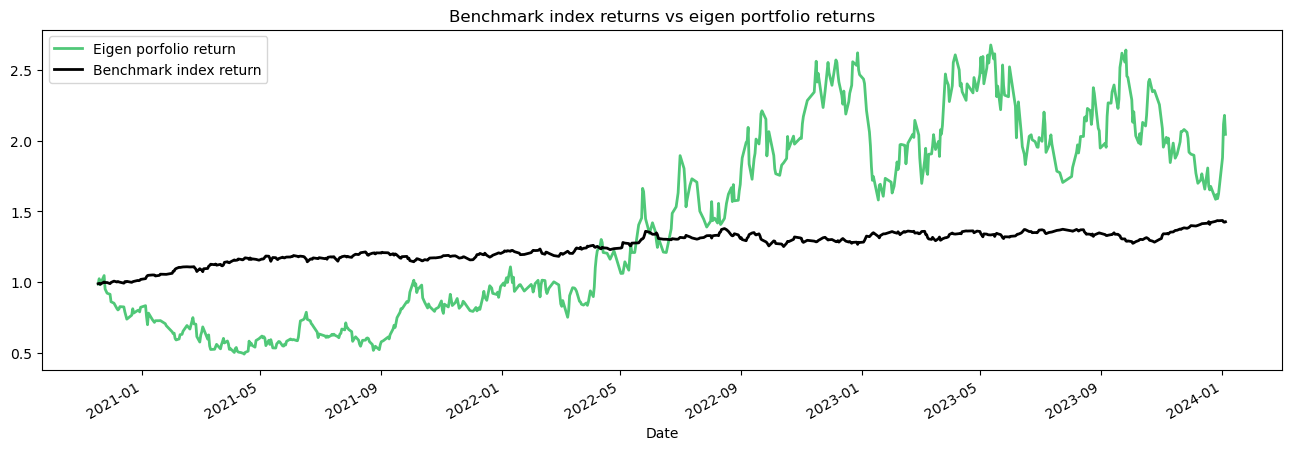

Current Eigen-Portfolio:
Return = -58.75%
Volatility = 165.13%
Sharpe = -0.36


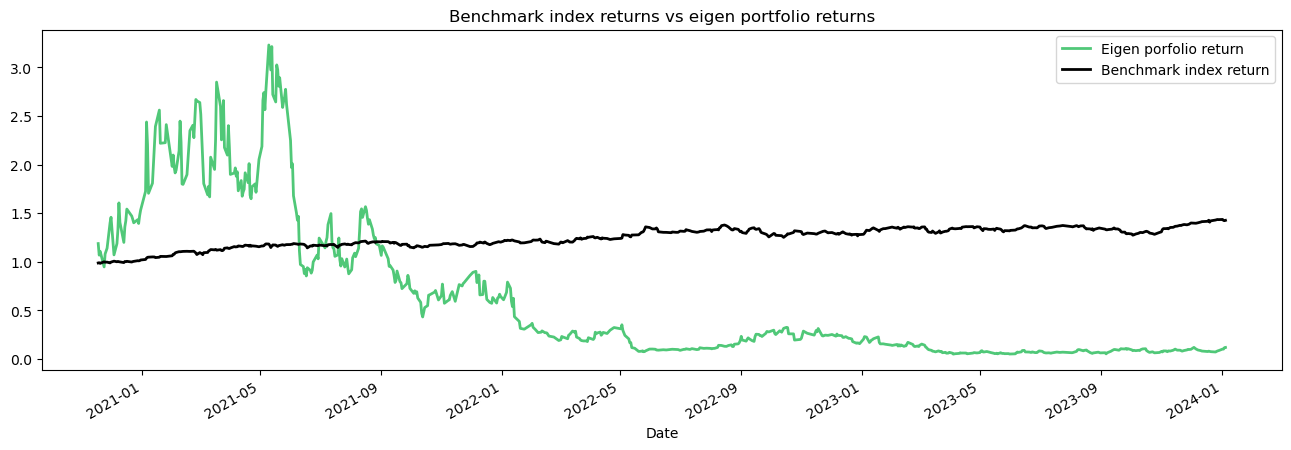

In [49]:
test(weight = weights[2])
test(weight = weights[6])
test(weight = weights[10])


## References

Bailey DH, López de Prado, M. The Sharpe Ratio Efficient Frontier. Journal of Risk. 2012; 15(2). doi: 10.2139/ssrn.1821643